In [1]:
import pandas as pd 
import numpy as np 
import glob
import matplotlib.pyplot as plt
from time import time

from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, f1_score
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.impute import SimpleImputer

# Differnt types of Naive Bayes Classifiers
from sklearn.naive_bayes import GaussianNB, CategoricalNB, BernoulliNB

pd.set_option('display.max_columns', None)

In [42]:
train_path = max(glob.glob('../train/*.csv'), key=os.path.getctime) 
df = pd.read_csv(train_path)

test_path = max(glob.glob('../test/*.csv'), key=os.path.getctime) 
test = pd.read_csv(test_path)

In [45]:
test.head()

,reward_tiers,min_reward,max_reward,goal,state,staff_pick,has_video,rewards_0,rewards_1,rewards_2,rewards_3,rewards_4,rewards_5,rewards_6,rewards_7,rewards_8,rewards_9,rewards_10,rewards_11,rewards_12,rewards_13,rewards_14,rewards_15,rewards_16,rewards_17,rewards_18,rewards_19,rewards_20,rewards_21,rewards_22,rewards_23,rewards_24,rewards_25,rewards_26,rewards_27,rewards_28,rewards_29,rewards_30,rewards_31,rewards_32,rewards_33,rewards_34,rewards_35,rewards_36,rewards_37,rewards_38,rewards_39,rewards_40,rewards_41,rewards_42,rewards_43,rewards_44,rewards_45,rewards_46,rewards_47,rewards_48,rewards_49,rewards_50,rewards_51,rewards_52,rewards_53,rewards_54,rewards_55,rewards_56,rewards_57,rewards_58,rewards_59,rewards_60,rewards_61,rewards_62,rewards_63,rewards_64,rewards_65,rewards_66,rewards_67,rewards_68,rewards_69,rewards_70,rewards_71,rewards_72,rewards_73,rewards_74,rewards_75,rewards_76,rewards_77,rewards_78,rewards_79,rewards_80,rewards_81,rewards_82,rewards_83,rewards_84,rewards_85,rewards_86,rewards_87,rewards_88,rewards_89,rewards_90,rewards_91,rewards_92,rewards_93,rewards_94,rewards_95,rewards_96,rewards_97,rewards_98,rewards_99,description_0,description_1,description_2,description_3,description_4,description_5,description_6,description_7,description_8,description_9,description_10,description_11,description_12,description_13,description_14,description_15,description_16,description_17,description_18,description_19,description_20,description_21,description_22,description_23,description_24,description_25,description_26,description_27,description_28,description_29,description_30,description_31,description_32,description_33,description_34,description_35,description_36,description_37,description_38,description_39,description_40,description_41,description_42,description_43,description_44,description_45,description_46,description_47,description_48,description_49,description_50,description_51,description_52,description_53,description_54,description_55,description_56,description_57,description_58,description_59,description_60,description_61,description_62,description_63,description_64,description_65,description_66,description_67,description_68,description_69,description_70,description_71,description_72,description_73,description_74,description_75,description_76,description_77,description_78,description_79,description_80,description_81,description_82,description_83,description_84,description_85,description_86,description_87,description_88,description_89,description_90,description_91,description_92,description_93,description_94,description_95,description_96,description_97,description_98,description_99,description_story_0,description_story_1,description_story_2,description_story_3,description_story_4,description_story_5,description_story_6,description_story_7,description_story_8,description_story_9,description_story_10,description_story_11,description_story_12,description_story_13,description_story_14,description_story_15,description_story_16,description_story_17,description_story_18,description_story_19,description_story_20,description_story_21,description_story_22,description_story_23,description_story_24,description_story_25,description_story_26,description_story_27,description_story_28,description_story_29,description_story_30,description_story_31,description_story_32,description_story_33,description_story_34,description_story_35,description_story_36,description_story_37,description_story_38,description_story_39,description_story_40,description_story_41,description_story_42,description_story_43,description_story_44,description_story_45,description_story_46,description_story_47,description_story_48,description_story_49,description_story_50,description_story_51,description_story_52,description_story_53,description_story_54,description_story_55,description_story_56,description_story_57,description_story_58,description_story_59,description_story_60,description_story_61,description_story_62,description_story_63,description_story_

## Get to the correct data format

In [46]:
X_train, y_train = df.drop('state', axis=1), df['state']
X_test, y_test = test.drop('state', axis=1), test['state']

In [47]:
train_ohe_cat = X_train.iloc[:, 422:437]
X_train['category'] = train_ohe_cat.idxmax(1)
train_ohe_loc = X_train.iloc[:, 437:-1]
X_train['location'] = train_ohe_loc.idxmax(1)

In [48]:
train_ohe_cat = X_test.iloc[:, 422:437]
X_test['category'] = train_ohe_cat.idxmax(1)
train_ohe_loc = X_test.iloc[:, 437:-1]
X_test['location'] = train_ohe_loc.idxmax(1)

In [49]:
X_train = X_train.drop(X_train.iloc[:, 422:-2].columns, axis=1)
X_test = X_test.drop(X_test.iloc[:, 422:-2].columns, axis=1)

## Mixed NB Approach 1 
convert continuous variables into categorical ones through binning and then train a categorical model

In [50]:
X_train1 = X_train.copy()
X_test1 = X_test.copy()
binary_cols = ['staff_pick', 'has_video']
train_numeric = X_train1.select_dtypes(include='number').drop(binary_cols, axis=1) 
test_numeric = X_test1.select_dtypes(include='number').drop(binary_cols, axis=1) 

In [51]:
for i, col in enumerate(train_numeric.columns):
    X_train1[col], val = pd.qcut(X_train1[col], 5, retbins = True, duplicates = 'drop')
    X_test1[col] = pd.cut(X_test1[col], bins = val, duplicates = 'drop', include_lowest=True)

In [52]:
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value = np.nan)
X_train1_fitted = enc.fit_transform(X_train1)
X_test1_fitted = enc.transform(X_test1)
imp = SimpleImputer(strategy="most_frequent") # impute nan values
X_train1_fitted = imp.fit_transform(X_train1_fitted)
X_test1_fitted = imp.transform(X_test1_fitted)
model_C = CategoricalNB()
clf_C = model_C.fit(X_train1_fitted, y_train)
y_pred = model_C.predict(X_test1_fitted)

In [53]:
# train classification report
y_train_pred = model_C.predict(X_train1_fitted)
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.56      0.69      0.62      7274
           1       0.86      0.77      0.81     17482

    accuracy                           0.75     24756
   macro avg       0.71      0.73      0.72     24756
weighted avg       0.77      0.75      0.76     24756



In [54]:
# test classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.55      0.70      0.62      1282
           1       0.86      0.76      0.81      3087

    accuracy                           0.74      4369
   macro avg       0.70      0.73      0.71      4369
weighted avg       0.77      0.74      0.75      4369



In [55]:
y_pred_prob = model_C.predict_proba(X_test1_fitted)[:, 1]
print('ROC_AUC: ', roc_auc_score(y_test, y_pred_prob))

ROC_AUC:  0.8109474233196733


## Mixed NB Approach 2
train three separate models using continuous, binary and categorical variables and then train the final model based on predictions from the three models

In [56]:
X_train2 = X_train.copy()
X_test2 = X_test.copy()
categorical_cols = ['category', 'location']
train_binary = X_train2[binary_cols]
train_categorical = X_train2[categorical_cols]
test_binary = X_test2[binary_cols]
test_categorical = X_test2[categorical_cols]

In [57]:
# ----- Fit three models -----

model_G = GaussianNB()
clf_G = model_G.fit(train_numeric, y_train)

model_C2 = CategoricalNB()
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value = np.nan)
train_categorical = enc.fit_transform(train_categorical)
test_categorical = enc.transform(test_categorical)
imp = SimpleImputer(strategy="most_frequent") 
train_categorical = imp.fit_transform(train_categorical)
test_categorical = imp.transform(test_categorical)
clf_C2 = model_C2.fit(train_categorical, y_train)

model_B = BernoulliNB()
clf_B = model_B.fit(train_binary, y_train)

# ----- Get probability predictions from each model -----
# On training data
G_train_probas = model_G.predict_proba(train_numeric)
C_train_probas = model_C2.predict_proba(train_categorical)
B_train_probas = model_B.predict_proba(train_binary)

# And on testing data
G_test_probas = model_G.predict_proba(test_numeric)
C_test_probas = model_C2.predict_proba(test_categorical)
B_test_probas = model_B.predict_proba(test_binary)

# Combine probability prediction for class=1 from both models
X_new_train = np.c_[(G_train_probas[:,1], C_train_probas[:,1], B_train_probas[:,1])] # Train
X_new_test = np.c_[(G_test_probas[:,1], C_test_probas[:,1], B_test_probas[:,1])] # Test


# ----- Fit Gaussian model on the X_new -----
model = GaussianNB()
clf = model.fit(X_new_train, y_train)
y_pred = model.predict(X_new_test)

In [58]:
# train classification report
y_train_pred = model.predict(X_new_train)
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.63      0.62      0.63      7274
           1       0.84      0.85      0.85     17482

    accuracy                           0.78     24756
   macro avg       0.74      0.73      0.74     24756
weighted avg       0.78      0.78      0.78     24756



In [59]:
# test classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.62      0.63      0.63      1282
           1       0.85      0.84      0.84      3087

    accuracy                           0.78      4369
   macro avg       0.73      0.74      0.74      4369
weighted avg       0.78      0.78      0.78      4369



In [60]:
y_pred_prob = model.predict_proba(X_new_test)[:, 1]
print('ROC_AUC: ', roc_auc_score(y_test, y_pred_prob))

ROC_AUC:  0.8159731539893278


## Hyperparameter Tuning

For approach 1:

In [61]:
param_grid1_nb = {
    'alpha': np.logspace(0,-9, num=100)
}
cv_method = RepeatedStratifiedKFold(n_splits=5, 
                                    n_repeats=3, 
                                    random_state=999)

In [62]:
model_grid1 = RandomizedSearchCV(estimator = CategoricalNB(), 
                            param_distributions = param_grid1_nb, 
                            verbose = 1, 
                            cv = cv_method,
                            scoring = 'roc_auc')
model_grid1.fit(X_train1_fitted, y_train)
print('--------------------------------------------------------')
print('Best Estimator: ', model_grid1.best_estimator_)

Fitting 15 folds for each of 10 candidates, totalling 150 fits
--------------------------------------------------------
Best Estimator:  CategoricalNB(alpha=0.657933224657568)


In [63]:
# train classification report
y_train_pred = model_grid1.predict(X_train1_fitted)
print(classification_report(y_train, y_train_pred, digits=5))

              precision    recall  f1-score   support

           0    0.55931   0.69233   0.61875      7274
           1    0.85792   0.77302   0.81326     17482

    accuracy                        0.74931     24756
   macro avg    0.70861   0.73268   0.71601     24756
weighted avg    0.77018   0.74931   0.75611     24756



In [64]:
print("F1 score:", f1_score(y_train, y_train_pred))

F1 score: 0.8132635253054101


In [65]:
# test classification report
y_pred = model_grid1.predict(X_test1_fitted)
print(classification_report(y_test, y_pred, digits=5))

              precision    recall  f1-score   support

           0    0.55003   0.69891   0.61560      1282
           1    0.85912   0.76255   0.80796      3087

    accuracy                        0.74388      4369
   macro avg    0.70458   0.73073   0.71178      4369
weighted avg    0.76843   0.74388   0.75152      4369



In [66]:
y_pred_prob = model_grid1.predict_proba(X_test1_fitted)[:, 1]
print('ROC_AUC: ', roc_auc_score(y_test, y_pred_prob))

ROC_AUC:  0.8110017500797213


For approach 2:

In [67]:
param_grid2_nb = {
    'var_smoothing': np.logspace(0,-9, num=100)
}

In [68]:
model_grid2 = RandomizedSearchCV(estimator = GaussianNB(), 
                            param_distributions = param_grid2_nb, 
                            verbose = 1, 
                            cv = cv_method,
                            scoring = 'roc_auc')
model_grid2.fit(X_new_train, y_train)
print('--------------------------------------------------------')
print('Best Estimator: ', model_grid2.best_estimator_)

Fitting 15 folds for each of 10 candidates, totalling 150 fits
--------------------------------------------------------
Best Estimator:  GaussianNB(var_smoothing=0.0012328467394420659)


In [69]:
# train classification report
y_train_pred = model_grid2.predict(X_new_train)
print(classification_report(y_train, y_train_pred, digits=5))

              precision    recall  f1-score   support

           0    0.62921   0.62194   0.62555      7274
           1    0.84345   0.84750   0.84547     17482

    accuracy                        0.78122     24756
   macro avg    0.73633   0.73472   0.73551     24756
weighted avg    0.78050   0.78122   0.78085     24756



In [70]:
# test classification report
y_pred = model_grid2.predict(X_new_test)
print(classification_report(y_test, y_pred, digits=5))

              precision    recall  f1-score   support

           0    0.62519   0.62715   0.62617      1282
           1    0.84496   0.84386   0.84441      3087

    accuracy                        0.78027      4369
   macro avg    0.73508   0.73550   0.73529      4369
weighted avg    0.78047   0.78027   0.78037      4369



In [71]:
y_pred_prob = model_grid2.predict_proba(X_new_test)[:, 1]
print('ROC_AUC: ', roc_auc_score(y_test, y_pred_prob))

ROC_AUC:  0.8162340487788609


## Best NB Model
Approach 2 gives a slightly higher ROC_AUC score, with hyperparameter tuning making no significant difference to its performance.

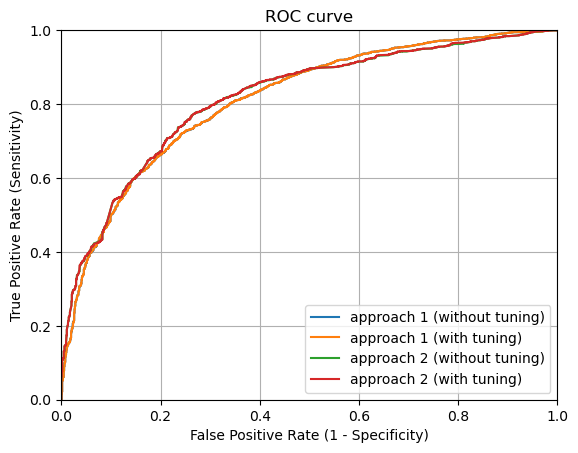

In [72]:
y_pred_prob1 = model_C.predict_proba(X_test1_fitted)[:, 1]
fpr1, tpr1, thresholds = roc_curve(y_test, y_pred_prob1)
y_pred_prob2 = model_grid1.predict_proba(X_test1_fitted)[:, 1]
fpr2, tpr2, thresholds = roc_curve(y_test, y_pred_prob2)
y_pred_prob3 = model.predict_proba(X_new_test)[:, 1]
fpr3, tpr3, thresholds = roc_curve(y_test, y_pred_prob3)
y_pred_prob4 = model_grid2.predict_proba(X_new_test)[:, 1]
fpr4, tpr4, thresholds = roc_curve(y_test, y_pred_prob4)
plt.plot(fpr1, tpr1, label = "approach 1 (without tuning)")
plt.plot(fpr2, tpr2, label ="approach 1 (with tuning)")
plt.plot(fpr3, tpr3, label = "approach 2 (without tuning)")
plt.plot(fpr4, tpr4, label ="approach 2 (with tuning)")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend()
plt.grid(True)

## Run time

In [35]:
total_time = 0
for i in range(100):
    start_time = time()
    model_time = CategoricalNB(alpha=0.657933224657568)
    clf = model_time.fit(X_train1_fitted, y_train)
    y_pred = model_time.predict(X_test1_fitted)
    run_time = time() - start_time
    total_time += run_time
avg_time = total_time / 100
print("Run time: ", avg_time)

Run time:  0.4698839831352234


In [36]:
total_time = 0
for i in range(100):
    start_time = time()
    model_time2 = GaussianNB(var_smoothing=0.0012328467394420659)
    clf = model_time2.fit(X_new_train, y_train)
    y_pred = model_time2.predict(X_new_test)
    run_time = time() - start_time
    total_time += run_time
avg_time = total_time / 100
print("Run time: ", avg_time)

Run time:  0.006142396926879883


## Feature importance

In [37]:
imps = permutation_importance(model_time, X_test1_fitted, y_test)

In [38]:
imps_sorted = imps.importances_mean.argsort()[::-1]

print(np.take(X_train1.columns, imps_sorted[: 20]))

Index(['rewards_1', 'rewards_0', 'success_rate', 'rewards_3', 'goal',
       'rewards_98', 'rewards_31', 'rewards_99', 'rewards_2', 'rewards_22',
       'funding_duration_in_days', 'rewards_47', 'description_story_16',
       'description_story_47', 'rewards_91', 'rewards_58',
       'description_story_80', 'description_story_85', 'description_story_57',
       'description_story_38'],
      dtype='object')
